In [1]:
import numpy as np
import tensorflow as tf
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile
import scipy as sp
import scipy.io as sio
import h5py as h5
from scipy.misc import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
from PIL import Image
from scipy import misc
%matplotlib inline

# Process the input and output data

In [2]:
def bboxHelper(f, attr):
        if len(attr) > 1:
            attr = [f[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

## Data representation - train.tar.tgz contains all images in .png and labels bounding box in matlab format digitStruct.mat
The digitStruct.mat file contains a struct called digitStruct with the same length as the number of original images. Each element in digitStruct has the following fields: name which is a string containing the filename of the corresponding image. bbox which is a struct array that contains the position, size and label of each digit bounding box in the image. Eg: digitStruct(300).bbox(2).height gives height of the 2nd digit bounding box in the 300th image
http://ufldl.stanford.edu/housenumbers/

In [3]:
train_dir = './data/train/'
train_location = './data/train/digitStruct.mat'
test_dir = './data/test/digitStruct.mat'
extra_dir = './data/extra/digitStruct.mat'

f = h5.File(train_location, 'r')
groups = f['digitStruct'].items()

digitStructName = f['digitStruct']['name']
digitStructBbox = f['digitStruct']['bbox']

num_of_samples = len(digitStructName)


# Checkout some random  images with its labels.

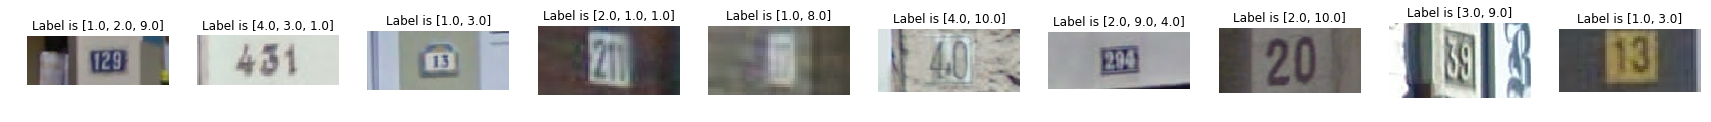

In [4]:
plt.rcParams['figure.figsize'] = (30.0, 30.0)
x, ax = plt.subplots(nrows=1, ncols=10)

for i in range(10):
    num = random.randrange(1, num_of_samples)
    ax[i].axis('off')
    bb = digitStructBbox[num].item()
    label = bboxHelper(f, f[bb]["label"])
    ax[i].set_title('Label is {}'.format(label), loc='center')
    name = ''.join([chr(c[0]) for c in f[digitStructName[num][0]].value])
    img_path = "./data/train/" + name
    image = mpimg.imread(img_path)
    ax[i].imshow(image)

In [5]:
""""The DigitStructFile is just a wrapper around the h5py data.  It basically references """
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

# Return a restructured version of the dataset (one structure by boxed digit).
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                figure['label']  = pictDat[i]['label'][j]
                figure['left']   = pictDat[i]['left'][j]
                figure['top']    = pictDat[i]['top'][j]
                figure['width']  = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [6]:
train = DigitStructFile(train_location)
train_data = train.getAllDigitStructure_ByDigit()
test = DigitStructFile(test_dir)
test_data = test.getAllDigitStructure_ByDigit()

In [7]:
extra = DigitStructFile(extra_dir)
extra_data = extra.getAllDigitStructure_ByDigit()

In [8]:
train_data[0]

{'boxes': [{'height': 219.0,
   'label': 1.0,
   'left': 246.0,
   'top': 77.0,
   'width': 81.0},
  {'height': 219.0, 'label': 9.0, 'left': 323.0, 'top': 81.0, 'width': 96.0}],
 'filename': '1.png'}

In [9]:
test_data[0]

{'boxes': [{'height': 30.0,
   'label': 5.0,
   'left': 43.0,
   'top': 7.0,
   'width': 19.0}],
 'filename': '1.png'}

In [10]:
extra_data[0]

{'boxes': [{'height': 56.0,
   'label': 4.0,
   'left': 24.0,
   'top': 70.0,
   'width': 38.0},
  {'height': 56.0, 'label': 7.0, 'left': 55.0, 'top': 41.0, 'width': 36.0},
  {'height': 56.0, 'label': 8.0, 'left': 79.0, 'top': 23.0, 'width': 47.0}],
 'filename': '1.png'}

In [11]:
print(len(train_data))

33402


In [12]:
print(len(test_data))

13068


In [13]:
print(len(extra_data))

202353


In [14]:
def display_random_images(dataset,location, num_images):
    import os
    dataset_size = len(dataset)
    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    x, ax = plt.subplots(nrows=1, ncols=num_images)
    y = 0
    for i in range(num_images):
        num = random.randrange(1, dataset_size)
        fin = os.path.join(location, dataset[num]['filename'])
        im = Image.open(fin)
    
        boxes = dataset[num]['boxes']
        if len(boxes) > 5:
            print(fin, "has more than 5 digits")
        else:
            left = [j['left'] for j in boxes]
            top = [j['top'] for j in boxes]
            height = [j['height'] for j in boxes]
            width = [j['width'] for j in boxes]
            lab = [j['label'] for j in boxes]
            im_left = min(left)
            im_top = min(top)
            im_height = max(top) + max(height) - im_top
            im_width = max(left) + max(width) - im_left
        ax[y].set_title('{}'.format(lab), loc='center')
        ax[y].imshow(im)
        y += 1

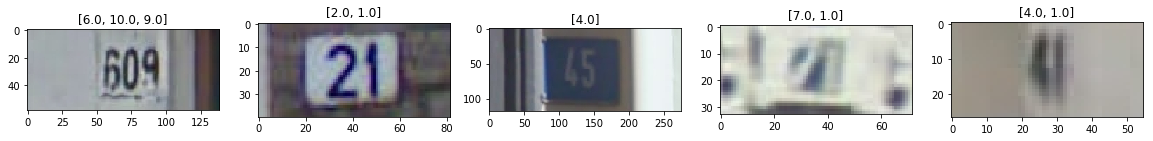

In [15]:
display_random_images(train_data, './data/train/', 5)

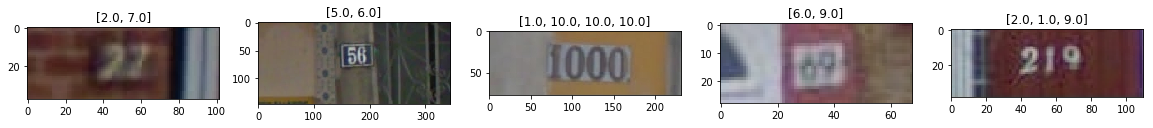

In [16]:
display_random_images(test_data, './data/test/', 5)

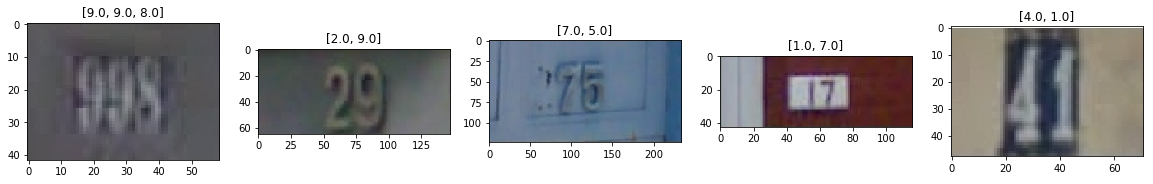

In [17]:
display_random_images(extra_data, './data/extra/', 5)

In [18]:
def display_rand_cropped_images(dataset,location):
    import os
    dataset_size = len(dataset)
    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    x, ax = plt.subplots(nrows=1, ncols=10)
    y=-1
    for i in range(5):
        num = random.randrange(1, dataset_size)
        fin = os.path.join(location, dataset[num]['filename'])
        im = Image.open(fin)
    
        boxes = dataset[num]['boxes']
        if len(boxes) > 5:
            print(fin, "has more than 5 digits")
        else:
            left = [j['left'] for j in boxes]
            top = [j['top'] for j in boxes]
            height = [j['height'] for j in boxes]
            width = [j['width'] for j in boxes]
            lab = [j['label'] for j in boxes]
            im_left = min(left)
            im_top = min(top)
            im_height = max(top) + max(height) - im_top
            im_width = max(left) + max(width) - im_left

        im_top = im_top - im_height * 0.05 # a bit higher
        im_left = im_left - im_width * 0.05 # a bit wider
        im_bottom = np.amin([np.ceil(im_top + 1.2 * im_height), im.size[1]])
        im_right = np.amin([np.ceil(im_left + 1.2 * im_width), im.size[0]])
        box =[im_left, im_top, im_right, im_bottom]

        y= y+1
        ax[y].set_title('Actual-{}'.format(lab), loc='center')
        ax[y].imshow(im)
        size = (64,64)
        region = im.crop(box).resize(size, Image.ANTIALIAS)
        y= y+1
        ax[y].set_title('Cropped-{}'.format(lab), loc='center')
        ax[y].imshow(region)


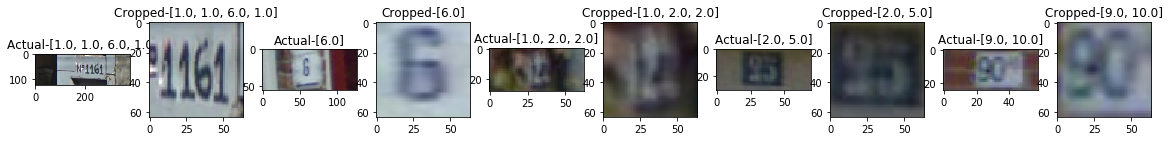

In [19]:
display_rand_cropped_images(train_data, './data/train/')

In [20]:
def get_dataset(data, location):
    dataset = np.ndarray([len(data),64,64,3], dtype='float32')
    labels = np.ones([len(data), 6], dtype=int) * 10
    for i in range(len(data)): 
        fin = os.path.join(location, data[i]['filename'])
        im = Image.open(fin)
        boxes = data[i]['boxes']
        num_digits = len(boxes)
        if num_digits > 5:
            print(fin, "has more than 5 digits")
        else:
            left = [j['left'] for j in boxes]
            top = [j['top'] for j in boxes]
            height = [j['height'] for j in boxes]
            width = [j['width'] for j in boxes]
            lab = [j['label'] for j in boxes]
            labels[i,0] = num_digits
            for k in np.arange(num_digits):
                labels[i,k+1] = lab[k]

        im_left = min(left)
        im_top = min(top)
        im_height = max(top) + max(height) - im_top
        im_width = max(left) + max(width) - im_left

        im_top = im_top - im_height * 0.05 # a bit higher
        im_left = im_left - im_width * 0.05 # a bit wider
        im_bottom = np.amin([np.ceil(im_top + 1.2 * im_height), im.size[1]])
        im_right = np.amin([np.ceil(im_left + 1.2 * im_width), im.size[0]])
        box =[im_left, im_top, im_right, im_bottom]
        region = im.crop(box).resize([64,64], Image.ANTIALIAS)
        reg_array = np.array(region, dtype='float32')
        reg = np.dot(reg_array, [[0.2989],[0.5870],[0.1140]])
        mean = np.mean(reg, dtype='float32')
        std = np.std(reg, dtype='float32', ddof=1)
        if std < 1e-4: std = 1.
        reg = (reg - mean) / std
        dataset[i,:,:,:] = reg[:,:,:]
    return dataset, labels

In [21]:
train_dataset, train_labels = get_dataset(train_data, './data/train/')


./data/train/29930.png has more than 5 digits


In [22]:
test_dataset, test_labels = get_dataset(test_data, './data/test/')

In [23]:
print("Training data Shape", train_dataset.shape)
print("Labels data Shape", train_labels.shape)

Training data Shape (33402, 64, 64, 3)
Labels data Shape (33402, 6)


In [24]:
print("Test data Shape", test_dataset.shape)
print("Labels data Shape", test_labels.shape)

Test data Shape (13068, 64, 64, 3)
Labels data Shape (13068, 6)


In [25]:
extra_dataset, extra_labels = get_dataset(extra_data, './data/extra/.')

In [26]:
print("Extra data Shape", extra_dataset.shape)
print("Labels data Shape", extra_labels.shape)

Extra data Shape (202353, 64, 64, 3)
Labels data Shape (202353, 6)


In [59]:
total_num_samples = len(train_data) + len(extra_data)
num_train_samples =int(total_num_samples *0.8)
num_validation_samples = total_num_samples - num_train_samples

concat_train_samples = np.concatenate((train_dataset, extra_dataset), axis=0)
concat_train_labels = np.concatenate((train_labels, extra_labels), axis=0)
train_samples = concat_train_samples[0:num_train_samples,:,:,:]
tran_labels = concat_train_labels[0:num_train_samples,:]

validation_samples = concat_train_samples[num_train_samples:, :,:,:]
validation_labels = concat_train_labels[num_train_samples:, :]

In [60]:
train_samples.shape

(188604, 64, 64, 3)

In [61]:
validation_samples.shape

(47151, 64, 64, 3)

In [62]:
validation_labels.shape

(47151, 6)

# Build The network

In [63]:
def conv2d_maxpool(x, output_size, kernel_size, conv_stride_size, pool_size, pool_stride):

    shape = x.get_shape().as_list()
    W_conv1 = tf.Variable(tf.random_normal([kernel_size,kernel_size,shape[3],output_size],stddev=0.1))
    b_conv1 = tf.zeros([output_size])
    conv = tf.nn.conv2d(x, W_conv1, strides=[1,conv_stride_size, conv_stride_size,1], padding='SAME') + b_conv1
    conv = tf.nn.relu(conv)
    max_pool = tf.nn.max_pool(conv, ksize=[1,pool_size,pool_size,1], strides=[1,pool_stride,pool_stride,1], padding='SAME')
    return max_pool

In [64]:
def flatten(x):
    shape = x.get_shape().as_list()
    dim = np.prod(shape[1:])
    x2 = tf.reshape(x, [-1, dim])
    return x2

In [65]:
def fully_conn_relu(x, num_outputs):
    shape = x.get_shape().as_list()
    W_fc = tf.Variable(tf.random_normal([shape[1], num_outputs],stddev=0.1))
    b_fc = tf.zeros(num_outputs)
    fc = tf.nn.relu(tf.matmul(x, W_fc) + b_fc)
    return fc

In [66]:
def output(x, num_output):
    shape = x.get_shape().as_list()
    W_fc = tf.Variable(tf.random_normal([shape[1], num_output],stddev=0.1))
    b_fc = tf.zeros(num_output)
    output = tf.matmul(x, W_fc) + b_fc
    return output

In [67]:
num_classes = 11
def conv_net (x, keep_prob):
    conv1 = conv2d_maxpool(tf_input, 32, 5, 2, 2, 2)
    drop_data = tf.nn.dropout(conv1, keep_prob)

    conv2 = conv2d_maxpool(drop_data, 32,5,2, 2, 2)
    flatten_output = flatten(tf_input)
    flat_shape = flatten_output.get_shape().as_list()
    fc1 = fully_conn_relu(flatten_output, 1024)
    out_1 = output(fc1, num_classes)
    out_2 = output(fc1, num_classes)
    out_3 = output(fc1, num_classes)
    out_4 = output(fc1, num_classes)
    out_5 = output(fc1, num_classes)
    return out_1, out_2, out_3, out_4, out_5


In [68]:
epochs = 1
batch_size = 64
keep_probability = 0.5

In [69]:
tf.reset_default_graph()

# Inputs
tf_input = tf.placeholder(tf.float32, shape=[None, 64, 64, 3],name='tf_input')
tf_output = tf.placeholder(tf.int64, shape=[None, 6], name='tf_output')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# Model
logits1, logits2, logits3, logits4, logits5 = conv_net(tf_input, keep_prob)

cost =  tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits1, labels=tf_output[:,1])) + \
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits2, labels=tf_output[:,2])) + \
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits3, labels=tf_output[:,3])) + \
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits4, labels=tf_output[:,4])) + \
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits5, labels=tf_output[:,5]))

optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
prediction = tf.stack([tf.nn.softmax(logits1),
                      tf.nn.softmax(logits2),
                      tf.nn.softmax(logits3),
                      tf.nn.softmax(logits4),
                      tf.nn.softmax(logits5)])

arg = tf.transpose(tf.argmax(prediction,2))
equality = tf.equal(arg, tf_output[:,1:6])
acc = tf.reduce_mean(tf.cast(equality, tf.float32))

In [70]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    session.run([optimizer], feed_dict={tf_input:feature_batch, tf_output:label_batch, keep_prob: keep_probability})
    #pass

In [71]:
def print_train_stats(sess, features_input, feature_labels):
    loss = sess.run(cost, feed_dict={tf_input:features_input, tf_output:feature_labels, keep_prob: 1})
    train_acc = sess.run(acc,feed_dict={tf_input:features_input, tf_output:feature_labels, keep_prob: 1})
    print("Training Loss=", loss)
    print("Final Acc=", train_acc)

In [75]:
def print_valid_stats(sess, features_input, feature_labels):
    valid_acc = sess.run(acc,feed_dict={tf_input:features_input, tf_output:feature_labels, keep_prob: 1})
    print("Validation Acc=", valid_acc)

In [76]:
def test_trained_data(sess): 
    test_steps = int(len(test_data) / batch_size)
    cap_input = test_dataset[0:test_steps*batch_size, :,:,:]
    cap_output = test_labels[0:num_of_steps*batch_size, :]
    test_batch_acc_total = 0
    num_of_batches=0

    for steps in range(test_steps):
        offset = steps * batch_size
        test_input_batch = cap_input[offset: (offset +batch_size), :, :, :]
        test_ouput_batch = cap_output[offset: (offset +batch_size), :]
        test_acc = sess.run(acc,
                feed_dict={tf_input:test_input_batch, tf_output:test_ouput_batch, keep_prob: 1})
        test_batch_acc_total += test_acc
        num_of_batches += 1
    
    print("Test Accuracy", test_batch_acc_total/num_of_batches)

In [ ]:
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    valid_offset =0
    for epoch in range(epochs):

        num_of_steps = int(len(train_samples) / batch_size)
        cap_input = train_samples[0:num_of_steps*batch_size, :,:,:]
        cap_output = train_labels[0:num_of_steps*batch_size, :]
        if valid_offset > (len(validation_samples)-batch_size):
            valid_offset=0
        for steps in range(num_of_steps):
            offset = steps * batch_size
            train_input_batch = cap_input[offset: (offset +batch_size), :, :, :]
            train_ouput_batch = cap_output[offset: (offset +batch_size), :]
            train_neural_network(sess, optimizer, keep_probability, train_input_batch, train_ouput_batch)
            if (steps % 500 == 0):
                print_train_stats(sess, train_input_batch, train_ouput_batch)
                valid_input_batch = validation_samples[valid_offset:(valid_offset+batch_size), :,:,:]
                valid_labels_batch = validation_labels[valid_offset:(valid_offset+batch_size),:]
                print_valid_stats(sess, valid_input_batch, valid_labels_batch)
                valid_offset +=1
    test_trained_data(sess)
    

Training Loss= 48.3449
Final Acc= 0.5875
Validation Acc= 0.2625


# Test Accuracy